In [1]:
import torch
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
y_train[0]

5

### Preprocess Data

In [5]:
X_train = torch.tensor(X_train.reshape(-1, 28 * 28), dtype=torch.float)
X_test = torch.tensor(X_test.reshape(-1, 28 * 28), dtype=torch.float)
y_train = torch.tensor(to_categorical(y_train))
y_test = torch.tensor(to_categorical(y_test))

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([60000, 784])
torch.Size([60000, 10])
torch.Size([10000, 784])
torch.Size([10000, 10])


### Create Model

In [7]:
layer_1 = torch.randn(784, 128) / np.sqrt(784) # Woo Xavier Initialisation
layer_2 = torch.randn(128, 10) / np.sqrt(128) # Somehow no overflow
layer_1.requires_grad_()
layer_2.requires_grad_()
def relu(X):
    return X * (X > 0)
def softmax(X):
    e_X = (X - X.amax(-1).unsqueeze(-1)).exp()
    return e_X / e_X.sum(-1).unsqueeze(-1)
def log_softmax(X): # Better than softmax?
    return X - X.exp().sum(-1).log().unsqueeze(-1)
def predict(X):
    X = X @ layer_1
    X = relu(X)
    X = X @ layer_2
    X = softmax(X)
    return X
def mse(y1, y2):
    return ((y1 - y2) ** 2).mean()
def realise(p):
    return p.argmax(axis=1)
def accuracy(y1, y2):
    return (realise(y1) == realise(y2)).float().mean()

### Train Model

In [8]:
def plot_stats(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
    print(f'Final Validation Accuracy of {val_acc[-1]}')
    print(f'Highest Validation Accuracy of {np.amax(val_acc)} at epoch {np.argmax(val_acc) + 1}')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    print(f'Final Validation Loss of {val_loss[-1]}')
    print(f'Lowest Validation Loss of {np.amin(val_loss)} at epoch {np.argmin(val_loss) + 1}')

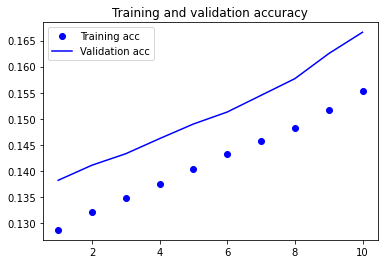

Final Validation Accuracy of 0.16660000383853912
Highest Validation Accuracy of 0.16660000383853912 at epoch 10


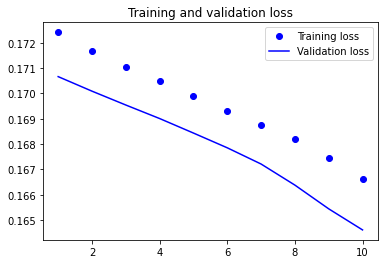

Final Validation Loss of 0.1646074652671814
Lowest Validation Loss of 0.1646074652671814 at epoch 10
Wall time: 20 s


In [9]:
%%time
lr = 1e-2
epochs = 10
hist_train_acc = [0] * epochs
hist_train_loss = [0] * epochs
hist_test_acc = [0] * epochs
hist_test_loss = [0] * epochs
for i in tqdm(range(epochs), disable=False):
    train_y = predict(X_train)
    train_loss = mse(train_y, y_train)
    train_loss.backward()
    #print(train_y)
    #print(train_loss)
    with torch.no_grad():
        layer_1 -= layer_1.grad * lr
        layer_2 -= layer_2.grad * lr
        layer_1.grad.zero_()
        layer_2.grad.zero_()
        # Collect Stats
        test_y = predict(X_test)
        test_loss = mse(test_y, y_test)
        test_acc = accuracy(test_y, y_test)
        train_acc = accuracy(train_y, y_train)
        hist_train_acc[i] = train_acc.item()
        hist_train_loss[i] = train_loss.item()
        hist_test_acc[i] = test_acc.item()
        hist_test_loss[i] = test_loss.item()
plot_stats(hist_train_acc, hist_test_acc, hist_train_loss, hist_test_loss)

### Moving to GPU

In [10]:
X_train = X_train.cuda()
X_test = X_test.cuda()
y_train = y_train.cuda()
y_test = y_test.cuda()
layer_1 = torch.randn(784, 128) / np.sqrt(784) # Woo Xavier Initialisation
layer_2 = torch.randn(128, 10) / np.sqrt(128) # Somehow no overflow
layer_1 = layer_1.cuda()
layer_2 = layer_2.cuda()
layer_1.requires_grad_()
layer_2.requires_grad_()

tensor([[ 0.0592, -0.1552, -0.0667,  ..., -0.0136,  0.1366,  0.0467],
        [-0.1247, -0.0064,  0.0792,  ..., -0.0754,  0.0793, -0.0403],
        [-0.0160,  0.0706,  0.1390,  ..., -0.0807,  0.1701, -0.0424],
        ...,
        [-0.0207, -0.0236, -0.0954,  ..., -0.0144, -0.1886,  0.0741],
        [ 0.0580,  0.0441,  0.0479,  ..., -0.0012,  0.0166,  0.0075],
        [-0.1736, -0.1492, -0.0068,  ..., -0.0670,  0.0624, -0.0134]],
       device='cuda:0', requires_grad=True)

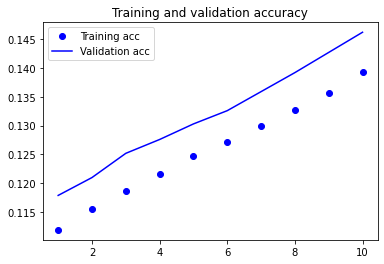

Final Validation Accuracy of 0.1462000012397766
Highest Validation Accuracy of 0.1462000012397766 at epoch 10


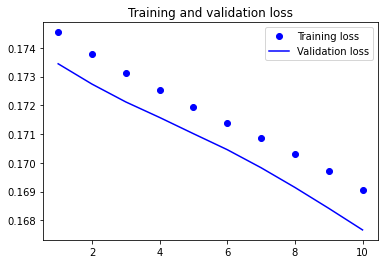

Final Validation Loss of 0.1676674336194992
Lowest Validation Loss of 0.1676674336194992 at epoch 10
Wall time: 3.1 s


In [11]:
%%time
lr = 1e-2
epochs = 10
hist_train_acc = [0] * epochs
hist_train_loss = [0] * epochs
hist_test_acc = [0] * epochs
hist_test_loss = [0] * epochs
for i in tqdm(range(epochs), disable=False):
    train_y = predict(X_train)
    train_loss = mse(train_y, y_train)
    train_loss.backward()
    #print(train_y)
    #print(train_loss)
    with torch.no_grad():
        layer_1 -= layer_1.grad * lr
        layer_2 -= layer_2.grad * lr
        layer_1.grad.zero_()
        layer_2.grad.zero_()
        # Collect Stats
        test_y = predict(X_test)
        test_loss = mse(test_y, y_test)
        test_acc = accuracy(test_y, y_test)
        train_acc = accuracy(train_y, y_train)
        hist_train_acc[i] = train_acc.item()
        hist_train_loss[i] = train_loss.item()
        hist_test_acc[i] = test_acc.item()
        hist_test_loss[i] = test_loss.item()
plot_stats(hist_train_acc, hist_test_acc, hist_train_loss, hist_test_loss)

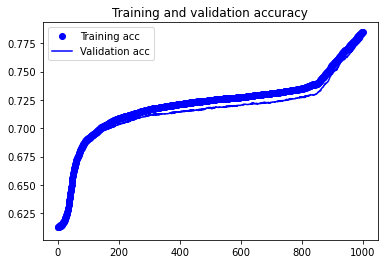

Final Validation Accuracy of 0.7793999910354614
Highest Validation Accuracy of 0.7793999910354614 at epoch 1000


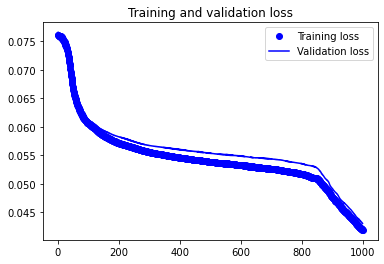

Final Validation Loss of 0.04308357834815979
Lowest Validation Loss of 0.04308357834815979 at epoch 1000
Wall time: 1min 27s


In [15]:
%%time
lr = 2e-2
epochs = 1000
hist_train_acc = [0] * epochs
hist_train_loss = [0] * epochs
hist_test_acc = [0] * epochs
hist_test_loss = [0] * epochs
for i in tqdm(range(epochs), disable=False):
    train_y = predict(X_train)
    train_loss = mse(train_y, y_train)
    train_loss.backward()
    #print(train_y)
    #print(train_loss)
    with torch.no_grad():
        layer_1 -= layer_1.grad * lr
        layer_2 -= layer_2.grad * lr
        layer_1.grad.zero_()
        layer_2.grad.zero_()
        # Collect Stats
        test_y = predict(X_test)
        test_loss = mse(test_y, y_test)
        test_acc = accuracy(test_y, y_test)
        train_acc = accuracy(train_y, y_train)
        hist_train_acc[i] = train_acc.item()
        hist_train_loss[i] = train_loss.item()
        hist_test_acc[i] = test_acc.item()
        hist_test_loss[i] = test_loss.item()
plot_stats(hist_train_acc, hist_test_acc, hist_train_loss, hist_test_loss)